# Train land price model
We will train a neural network to predict land prices using the hex2vec encodings as input data.

In [1]:
%load_ext autoreload
%autoreload 2
# %autoawait asyncio

In [2]:
%cd ..

d:\hex2vec2


## Import land price data and hex2vec encodings
After importing the data we also apply the logarithm on the land price column and will use that as target variable.

In [3]:
import pandas as pd
from src.settings import DATA_BRW, DATA_EMBEDDED_DIR
import numpy as np

In [4]:
df_brw = pd.read_feather(DATA_BRW.joinpath("concat.feather"))
df_brw = df_brw.drop(columns=["h3"])[df_brw.BRW<10000]

embedded_df = pd.read_feather(DATA_EMBEDDED_DIR.joinpath("embedded_9_brw"))
embedded_df.set_index("h3", inplace= True)

df_osm = pd.read_feather(DATA_EMBEDDED_DIR.joinpath("df_9_brw"))
df_osm.set_index("h3", inplace= True)

<Axes: ylabel='Frequency'>

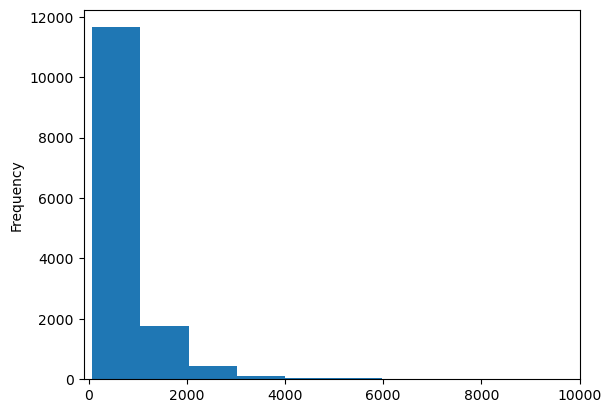

In [5]:
# distribution of BRW: Most values under 1000, but some really high values. We therefore apply the logarithm
df_brw.BRW.plot(kind = "hist",  xlim = (-100, 10000))

<Axes: ylabel='Frequency'>

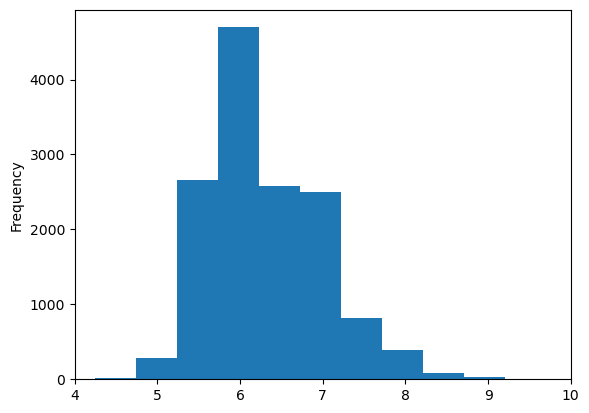

In [6]:
# distribution of log(BRW)
df_brw["BRW_log"] = df_brw.BRW.apply(lambda a: np.log(a))
df_brw.BRW_log.plot(kind = "hist", xlim = (4, 10))

## Train/test split

In [7]:
import sklearn.model_selection as skm

In [11]:
[train_set, test_set] = skm.train_test_split(df_brw, test_size = 0.1, random_state=0)

#define the set of descriptive features and the target feature for train and test set
X = train_set.drop(columns = ["BRW", "median", 'BRW_log', "geometry"])
y = train_set[['BRW_log']]

X_test = test_set.drop(columns = ["BRW", "median", 'BRW_log', "geometry"])
y_test = test_set[['BRW_log']]

## Normalize

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

X = pd.DataFrame(scaler_features.fit_transform(X), index=X.index, columns=X.columns)
y = pd.DataFrame(scaler_labels.fit_transform(y), index=y.index, columns=y.columns)

X_test = pd.DataFrame(scaler_features.transform(X_test), index=X_test.index, columns=X_test.columns)
y_test = pd.DataFrame(scaler_labels.transform(y_test), index=y_test.index, columns=y_test.columns)


## Build Training Data Set

In [ ]:
from src.models.h3_neighbor_dataset import H3NeighborTrainsetBRW

In [14]:
train_dataset = H3NeighborTrainsetBRW(X, y, embedded_df)

## Train

In [15]:
# import torch
import lightning.pytorch as pl
import pandas as pd
from torch.utils.data import DataLoader
from src.models.base_nn import BasicNN
from lightning.pytorch import seed_everything
from lightning.pytorch.tuner import Tuner

In [ ]:
# set seed for reproducibility
SEED = 42
seed_everything(SEED)

# set hyperparameter
data_shape = train_dataset.X.shape[1]
batch_size = 1000
learning_rate = 0.05
epochs = 85
sizes = [20, 20, 20, 1]

# set data, trainer and model
model = BasicNN([data_shape, *sizes], train_dataset, batch_size=batch_size, learning_rate=learning_rate)
trainer = pl.Trainer(max_epochs=epochs)

# tune batch size and learning rate
# tuner = Tuner(trainer)
# tuner.scale_batch_size(model, mode="power")
# tuner.lr_find(model)

In [ ]:
trainer.fit(model, ckpt_path="last")

## Evaluation
To evaluate our model we compute the mean/median absolute error on train and test set and compare it with the error of a dummy model that always predicts the median of the city the hexagon is in.

In [19]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
import numpy as np

In [20]:
test_dataset = H3NeighborTrainsetBRW(X_test, y_test, embedded_df)

In [171]:
# Error on train set

predictions = model.forward(train_dataset.X).detach().numpy()

y_unscaled = np.exp(scaler_labels.inverse_transform(y))
predictions_unscaled = np.exp(scaler_labels.inverse_transform(predictions))

print("The mean absolute error achieved on the train set is {0}.".format(mean_absolute_error(y_unscaled, predictions_unscaled)))
print("The median absolute error achieved on the train set is {0}.".format(median_absolute_error(y_unscaled, predictions_unscaled)))

The mean absolute error achieved on the train set is 107.80560354465216.
The median absolute error achieved on the train set is 58.46363067626943.


In [172]:
# Error on test set

predictions = model.forward(test_dataset.X).detach().numpy()

y_test_unscaled = np.exp(scaler_labels.inverse_transform(y_test))
predictions_test_unscaled = np.exp(scaler_labels.inverse_transform(predictions))

print("The mean absolute error achieved on the test set is {0}.".format(mean_absolute_error(y_test_unscaled, predictions_test_unscaled)))
print("The median absolute error achieved on the test set is {0}.".format(median_absolute_error(y_test_unscaled, predictions_test_unscaled)))

The mean absolute error achieved on the test set is 141.43544164795964.
The median absolute error achieved on the test set is 74.55648803710938.


In [22]:
# Error of dummy model on test set

print("The mean absolute error achieved by dummy model on the test set is {0}.".format(mean_absolute_error(test_set.BRW, test_set["median"])))
print("The median absolute error achieved by dummy model on the test set is {0}.".format(median_absolute_error(test_set.BRW, test_set["median"])))

The mean absolute error achieved by dummy model on the test set is 210.94594594594594.
The median absolute error achieved by dummy model on the test set is 90.0.


## Predictions for Bielefeld
The train/test split used above was a random split. I also tried using all cities but Bielefeld as train set and evaluated on Bielefelt as test data. These are the examples.

In [23]:
from src.data.make_dataset import h3_to_polygon
from src.analytics.visualization import plot_map

In [143]:
df_biele_pred = test_set.copy()

df_biele_pred["pred"] = predictions_test_unscaled
df_biele_pred["diff"] = df_biele_pred.BRW - df_biele_pred.pred

df_biele_pred['geometry'] = df_biele_pred.index.map(h3_to_polygon)

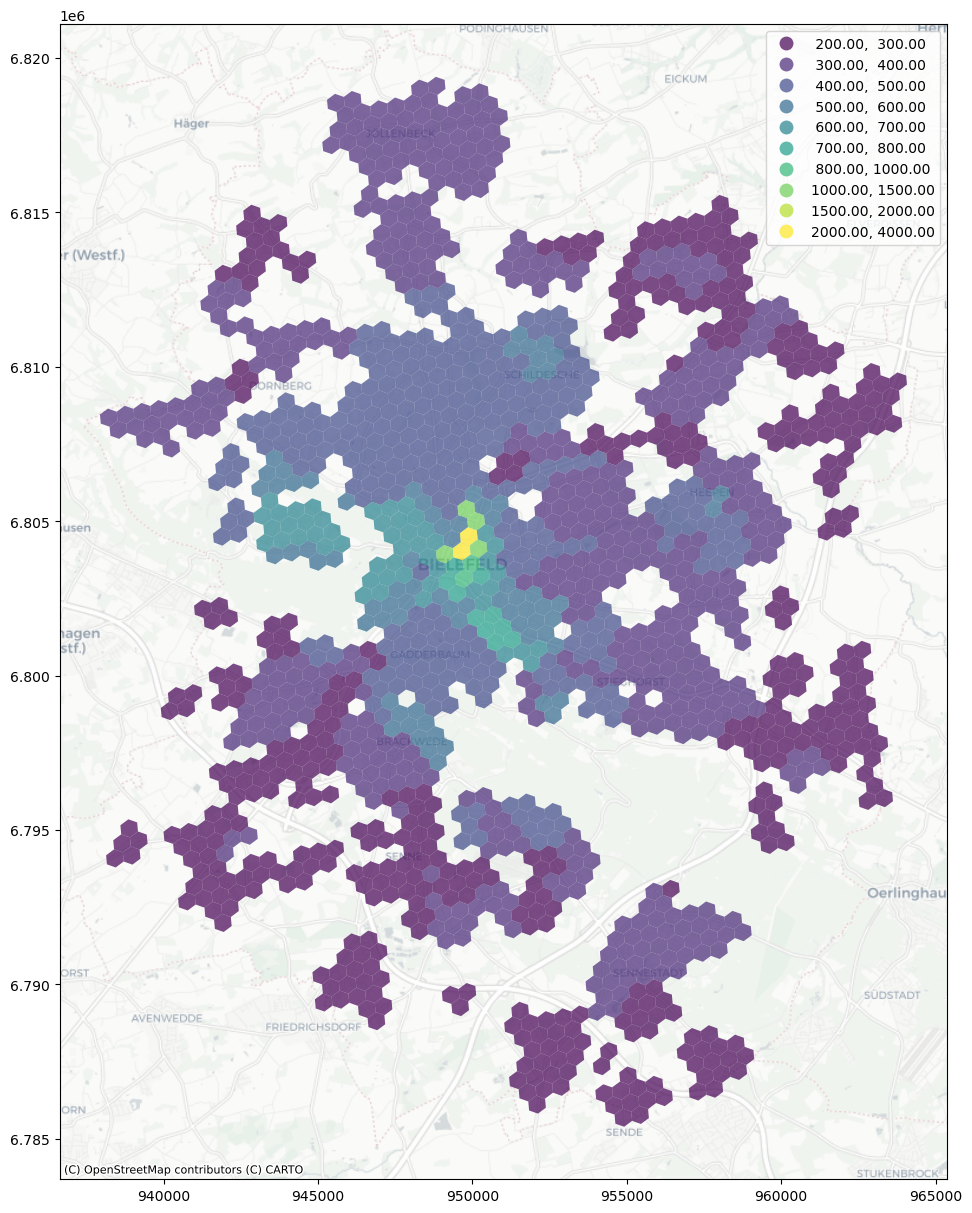

In [154]:
# True BRW for Bielefeld
plot_map(df_biele_pred, "BRW", bins = [300, 400, 500, 600, 700, 800, 1000, 1500, 2000, 4000])

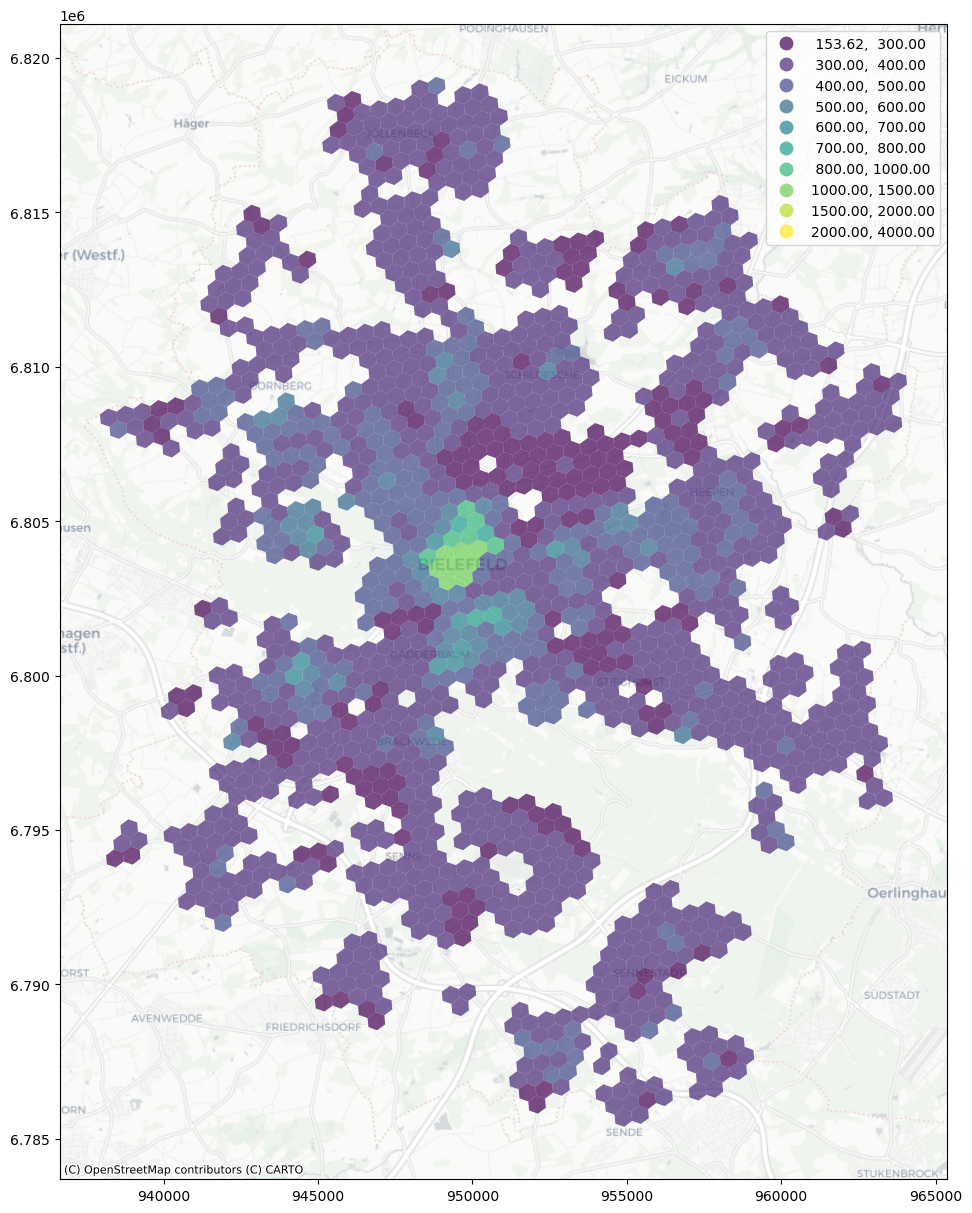

In [162]:
# Predicted BRW for Bielefeld
plot_map(df_biele_pred, "BRW", bins = [300, 400, 500, 600, 700, 800, 1000, 1500, 2000, 4000])